In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')

from jax import numpy as jnp
from jax import random as jr

import gaussfiltax.utils as utils
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import time
import gaussfiltax.inference as gf
from gaussfiltax.inference import ParamsUKF

from gaussfiltax.models import ParamsNLSSM, NonlinearSSM, ParamsBPF

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [2]:
# Parameters
state_dim = 1
state_noise_dim = 1
emission_dim = 1
emission_noise_dim = 1
seq_length = 100
mu0 = 0.0 * jnp.zeros(state_dim)
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.zeros(emission_noise_dim)
Sigma0 = 1.0 * jnp.eye(state_dim)
Q = 1.0 * jnp.eye(state_noise_dim)
R = 1.0 * jnp.eye(emission_noise_dim)

# ICASSP
# f1 = lambda x, q, u: (1-u) * x / 2.  + u * jnp.sin(10 * x) + q
f1 = lambda x, q, u: jnp.sin(10 * x) + q
g1 = lambda x, r, u:  1.0 * jnp.dot(x, x) + r
def g1lp(x,y,u):
    return MVN(loc = g1(x, r0, u), covariance_matrix = R).log_prob(y)


# Lorenz 63
def lorentz_63(x, sigma=10, rho=28, beta=2.667, dt=0.01):
    dx = dt * sigma * (x[1] - x[0])
    dy = dt * (x[0] * rho - x[1] - x[0] *x[2]) 
    dz = dt * (x[0] * x[1] - beta * x[2])
    return jnp.array([dx+x[0], dy+x[1], dz+x[2]])
f63 = lambda x, q, u: lorentz_63(x) + q

# stochastic growth model
f3 = lambda x, q, u: x / 2. + 25. * x / (1 + jnp.power(x, 2)) + u + q
g3 = lambda x, r, u: 0.8 * x + r
def g3lp(x,y,u):
    return MVN(loc = g3(x, 0.0, u), covariance_matrix = R).log_prob(y)


# Stochastic Volatility
alpha = 0.91
sigma = 1.0
beta = 0.5
fsv= lambda x, q, u: alpha * x + sigma * q
gsv = lambda x, r, u: beta * jnp.exp(x/2) * r
def svlp(x,y,u):
    return MVN(loc = gsv(x, r0, u), covariance_matrix = gsv(x, 1.0, u)**2 * R).log_prob(y)

# Linear - Stochastic Volatility
alpha = 0.91
sigma = 5.0
beta = 0.5
glsv = lambda x, r, u: u * beta * jnp.exp(x/2) * r + (1-u) * (0.8 * x + r)
def lsvlp(x,y,u):
    return MVN(loc = glsv(x, r0, u), covariance_matrix = u * beta ** 2 * jnp.exp(x) * R + (1-u) * R).log_prob(y)

# Multivariate SV
Phi = 0.8 * jnp.eye(state_dim)
fmsv = lambda x, q, u: Phi @ x + q #((1-u) + 0.3*u)*q
gmsv = lambda x, r, u:  u * 0.5 * jnp.multiply(jnp.exp(x/2), r)
def msvlp(x,y,u):
    return MVN(loc = gmsv(x, r0, u), covariance_matrix = jnp.diag(jnp.exp(x/2.0)) @ R @ jnp.diag(jnp.exp(x/2.0))).log_prob(y)

# Linear - Multivariate SV
sigma = 5.0
beta = 0.5

H = 0.1 * jnp.eye(emission_dim, state_dim)
glmsv = lambda x, r, u: H @ x + r
# lambda x, r, u: 0 * beta * jnp.multiply(jnp.exp(x / sigma), r) + (1-0) * (H @ x + r)
def lmsvlp(x,y,u):
    # M = 0 * beta * jnp.diag(jnp.exp(x / sigma)) + (1-0) * jnp.eye(emission_dim)
    M = jnp.eye(emission_dim)
    return MVN(loc = glmsv(x, r0, u), covariance_matrix = M @ R @ M.T).log_prob(y)

# Linear - Nonlinear mix
fLN = lambda x, q, u: 0.9 * jnp.array([x[0], x[1], jnp.sin(10 * x[2])]) + q
gLN = lambda x, r, u: 0.1 * jnp.eye(emission_dim, state_dim) @ x + r
gLNlp = lambda x,y,u: MVN(loc = gLN(x, 0.0, u), covariance_matrix = R).log_prob(y)

# Linear-Gaussian SSM
A = 0.8 * jnp.eye(state_dim)
H = 0.1 * jnp.eye(emission_dim, state_dim)
fLG = lambda x, q, u: A @ x + q
gLG = lambda x, r, u: H @ x + r
gLGlp = lambda x,y,u: MVN(loc = gLG(x, 0.0, u), covariance_matrix = R).log_prob(y)

# Inputs
# inputs = 8. * jnp.cos(1.2 * jnp.arange(seq_length))
# sm = lambda x : jnp.exp(x) / (1+jnp.exp(x))
# inputs = sm(jnp.arange(seq_length)-50) # off - on gradually
# inputs = jnp.array([0]*int(seq_length/2) + [1]*int(seq_length/2)) # off - on
inputs = 1.0 * jnp.zeros(seq_length) # off
# inputs = 1.0 * jnp.ones(seq_length) # on

In [3]:
f = f1
g = g1  
glp = g1lp

In [4]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

## Experiments

In [5]:
verbose = False
Nsim = 100
gsf_rmse = jnp.zeros(Nsim)
ugsf_rmse = jnp.zeros(Nsim)
agsf_rmse = jnp.zeros(Nsim)
uagsf_rmse = jnp.zeros(Nsim)
# agsf_opt_rmse = jnp.zeros(Nsim)
bpf_rmse = jnp.zeros(Nsim)
gsf_norm = jnp.zeros((Nsim, seq_length))
ugsf_norm = jnp.zeros((Nsim, seq_length))
agsf_norm = jnp.zeros((Nsim, seq_length))
uagsf_norm = jnp.zeros((Nsim, seq_length))
# agsf_opt_norm = jnp.zeros((Nsim, seq_length))
bpf_norm = jnp.zeros((Nsim, seq_length))
next_key = jr.PRNGKey(0)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    key, next_key = jr.split(next_key)
    states, emissions = model.sample(params, key, seq_length, inputs = inputs)
    
    # GSF
    M = 5
    tin = time.time()
    posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
    point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
    tout = time.time()
    print('       Time taken for GSF: ', tout - tin)

    # U-GSF
    uparams = ParamsUKF(1,0,0)
    M = 3
    tin = time.time()
    posterior_filtered_ugsf = gf.unscented_gaussian_sum_filter(params, uparams, emissions, M, 1, inputs)
    point_estimate_ugsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_ugsf.means, posterior_filtered_ugsf.weights), axis=0)
    tout = time.time()
    t_ugsf= tout - tin
    print('       Time taken for UGSF: ', tout - tin)

    # AGSF
    opt_args = (0.8, 1.0)
    tin = time.time()
    num_components = [M, 2, 2] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    print('       Time taken for AGSF: ', tout - tin)

    # U-AGSF
    tin = time.time()
    posterior_filtered_uagsf, aux_outputs = gf.unscented_agsf(params, uparams, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)
    point_estimate_uagsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_uagsf.means, posterior_filtered_uagsf.weights), axis=0)
    tout = time.time()
    t_uagsf= tout - tin
    print('       Time taken for UAGSF: ', tout - tin)

    # BPF
    tin = time.time()
    num_particles = 100

    params_bpf = ParamsBPF(
        initial_mean=mu0,
        initial_covariance=Sigma0,
        dynamics_function=f,
        dynamics_noise_bias=q0,
        dynamics_noise_covariance=Q,
        emission_function=g,
        emission_noise_bias=r0,
        emission_noise_covariance=R,
        emission_distribution_log_prob = glp
    )

    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()
    print('       Time taken for BPF: ', tout - tin)

    # Computation of errors
    gsf_rmse = gsf_rmse.at[i].set(utils.rmse(point_estimate_gsf, states))
    ugsf_rmse = ugsf_rmse.at[i].set(utils.rmse(point_estimate_ugsf, states))
    agsf_rmse = agsf_rmse.at[i].set(utils.rmse(point_estimate_agsf, states))
    uagsf_rmse = uagsf_rmse.at[i].set(utils.rmse(point_estimate_uagsf, states))
    bpf_rmse = bpf_rmse.at[i].set(utils.rmse(point_estimate_bpf, states))

    print('              GSF RMSE:', gsf_rmse[i])
    print('              UGSF RMSE:', ugsf_rmse[i])                                                                           
    print('              AGSF RMSE:', agsf_rmse[i])
    print('              UAGSF RMSE:', uagsf_rmse[i])
    print('              BPF RMSE:', bpf_rmse[i])

    gsf_norm = gsf_norm.at[i].set(jnp.linalg.norm(point_estimate_gsf - states, axis = 1))
    ugsf_norm = ugsf_norm.at[i].set(jnp.linalg.norm(point_estimate_ugsf - states, axis = 1))
    agsf_norm = agsf_norm.at[i].set(jnp.linalg.norm(point_estimate_agsf - states, axis = 1))
    uagsf_norm = uagsf_norm.at[i].set(jnp.linalg.norm(point_estimate_uagsf - states, axis = 1))
    bpf_norm = bpf_norm.at[i].set(jnp.linalg.norm(point_estimate_bpf - states, axis = 1))


sim 1/100
       Time taken for GSF:  0.33352208137512207
       Time taken for UGSF:  0.567997932434082
       Time taken for AGSF:  2.7970831394195557
       Time taken for UAGSF:  2.7877678871154785
       Time taken for BPF:  0.6825590133666992
              GSF RMSE: 3.3499908
              UGSF RMSE: 216536.1
              AGSF RMSE: 1.5425578
              UAGSF RMSE: 29565.473
              BPF RMSE: 1.1968453
sim 2/100
       Time taken for GSF:  0.14089584350585938
       Time taken for UGSF:  0.39246702194213867
       Time taken for AGSF:  2.5708258152008057
       Time taken for UAGSF:  2.8170831203460693
       Time taken for BPF:  0.376511812210083
              GSF RMSE: 3.1024954
              UGSF RMSE: 182210.44
              AGSF RMSE: 1.5966858
              UAGSF RMSE: 37878.918
              BPF RMSE: 1.387398
sim 3/100
       Time taken for GSF:  0.1457221508026123
       Time taken for UGSF:  0.3952171802520752
       Time taken for AGSF:  2.717521905899048
   

In [ ]:
ind = jnp.argwhere(jnp.isnan(gsf_norm[:,99])).flatten()                                                                                                                                     
gsf_norm = jnp.delete(gsf_norm, ind, axis = 0)                                                                                                                        

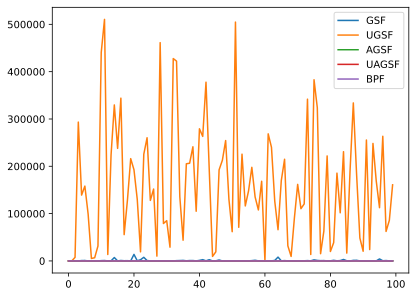

In [ ]:
plt.plot(gsf_norm.sum(axis=0)/(Nsim-len(ind)) , label = 'GSF')
plt.plot(ugsf_norm.sum(axis=0)/Nsim, label = 'UGSF')
plt.plot(agsf_norm.sum(axis=0)/Nsim, label = 'AGSF')
plt.plot(uagsf_norm.sum(axis=0)/Nsim, label = 'UAGSF')
# plt.plot(agsf_opt_norm.sum(axis=0)/Nsim, label = 'AGSF Optimal')
plt.plot(bpf_norm.sum(axis=0)/Nsim, label = 'BPF')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
gsf_armse = jnp.mean(gsf_rmse)
ugsf_armse = jnp.mean(ugsf_rmse)
agsf_armse = jnp.mean(agsf_rmse[1:])
uagsf_armse = jnp.mean(uagsf_rmse[1:])
# agsf_opt_armse = jnp.mean(agsf_opt_rmse[1:])
bpf_armse = jnp.mean(bpf_rmse)

gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, jnp.std(gsf_rmse))
ugsf_tab_out = '{:10.2f}±{:10.2f}'.format(ugsf_armse, jnp.std(ugsf_rmse))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, jnp.std(agsf_rmse))
uagsf_tab_out = '{:10.2f}±{:10.2f}'.format(uagsf_armse, jnp.std(uagsf_rmse))
# agsf_opt_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_opt_armse, jnp.std(agsf_opt_rmse))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, jnp.std(bpf_rmse))

# gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, np.std(gsf_time))
# agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, np.std(agsf_time))
# bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, np.std(bpf_time))

df = pd.DataFrame(columns = [' ','RMSE','time(s)'])
df[' '] = ['GSF', 'U-GSF', 'AGSF', 'U-AGSF', 'BPF']
df['RMSE'] = [gsf_tab_out, ugsf_tab_out, agsf_tab_out, uagsf_tab_out, bpf_tab_out]  
#  df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))  
df

\begin{tabular}{lll}
\toprule
  & RMSE & time(s) \\
\midrule
GSF &    2113.74±      0.00 & NaN \\
U-GSF &  204404.62±      0.00 & NaN \\
AGSF &        nan±      0.00 & NaN \\
U-AGSF &        nan±      0.00 & NaN \\
BPF &       1.22±      0.00 & NaN \\
\bottomrule
\end{tabular}



,,RMSE,time(s)
0,GSF,2113.74± 0.00,NaN
1,U-GSF,204404.62± 0.00,NaN
2,AGSF,nan± 0.00,NaN
3,U-AGSF,nan± 0.00,NaN
4,BPF,1.22± 0.00,NaN


## Plots

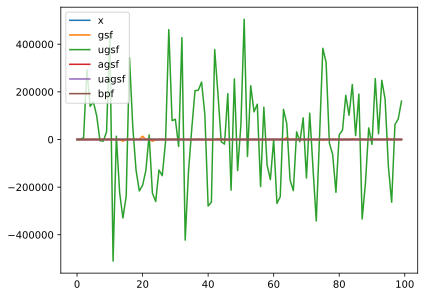

In [ ]:
plt.plot(sharex=True, figsize=(20, 7))
plt.plot(states, label = 'x')
plt.plot(point_estimate_gsf, label = 'gsf')
plt.plot(point_estimate_ugsf, label = 'ugsf')
plt.plot(point_estimate_agsf, label = 'agsf')
plt.plot(point_estimate_uagsf, label = 'uagsf')
plt.plot(point_estimate_bpf, label = 'bpf')
plt.legend()
plt.show()

### GSF

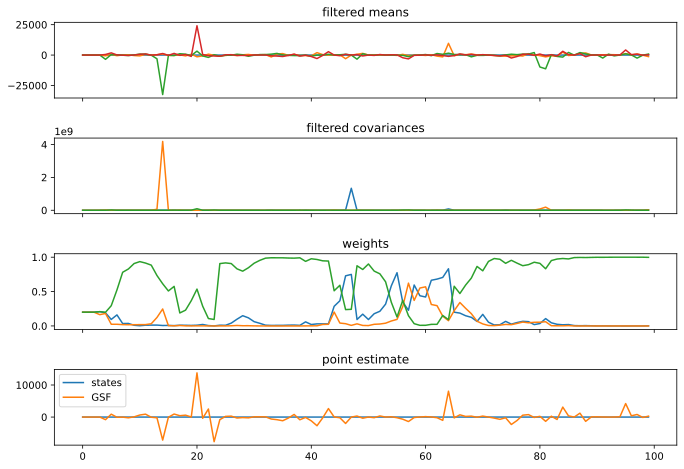

In [ ]:
num_components = M

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_gsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")
#axes[0].legend(leg)

if state_dim ==1:
    for m in range(M):
        axes[1].plot(posterior_filtered_gsf.covariances[m].squeeze())
        axes[1].set_title("filtered covariances")

for m in range(M):
    axes[2].plot(posterior_filtered_gsf.weights[m])
    axes[2].set_title("weights")

axes[3].plot(states, label="xs")
leg = ["states", "GSF"]
axes[3].plot(point_estimate_gsf)
axes[3].legend(leg)
axes[3].set_title("point estimate")
plt.show()

### AGSF

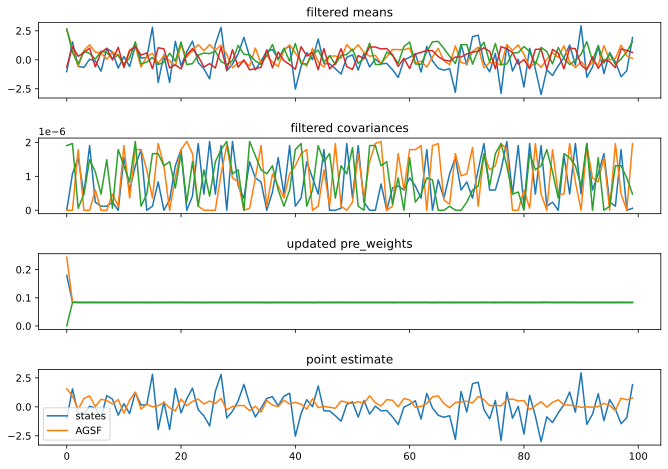

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_agsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")

#axes[0].legend(leg)

if state_dim == 1:
    for m in range(M):
        axes[1].plot(posterior_filtered_agsf.covariances[m].squeeze())
        axes[1].set_title("filtered covariances")

else:
    for m in range(jnp.prod(num_components)):
        axes[1].plot(aux_outputs["updated_means"][:,m])
        axes[1].set_title("updated means")

for m in range(jnp.prod(num_components)):
        axes[2].plot(aux_outputs["pre_weights"][:,m])
        axes[2].set_title("updated pre_weights")

axes[3].plot(states, label="xs")
leg = ["states", "AGSF"]
axes[3].plot(point_estimate_agsf)
axes[3].legend(leg)
axes[3].set_title("point estimate")

plt.show()

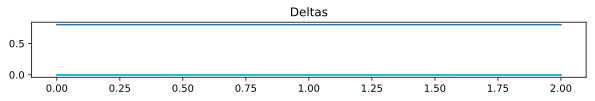

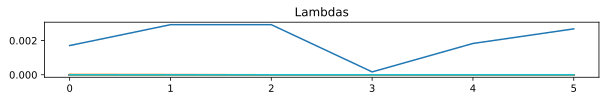

KeyError: 'grads_dyn'

<Figure size 1000x100 with 0 Axes>

In [ ]:
# plot Deltas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Deltas"].shape[0]):
    plt.plot(aux_outputs["Deltas"][i, :, 0])
plt.title('Deltas')
plt.show()

# plot Lambdas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Lambdas"].shape[0]):
    plt.plot(aux_outputs["Lambdas"][i, :, 0])
plt.title('Lambdas')
plt.show()

# plot grads_dyn
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][i, :, 0, 0])
plt.title('grad_dyn')
plt.show()

# plot grads_obs
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_obs"].shape[0]):
    plt.plot(aux_outputs["grads_obs"][i, :, 0, 0])
plt.title('grad_obs')
plt.show()

# plot gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["gain"].shape[0]):
    plt.plot(aux_outputs["gain"][i, :, 0, 0])
plt.title('gain')
plt.show()

# plot grads_dyn / gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][:, i, 0, 0] / aux_outputs["gain"][:, i * 3, 0, 0])
plt.title('grad / gain')
plt.show()

### BPF

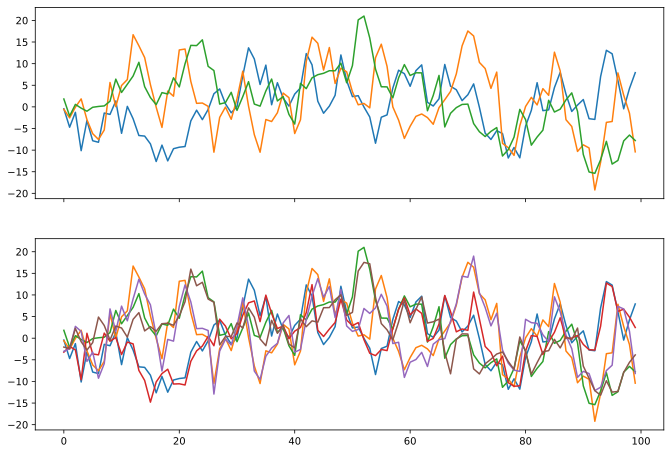

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
# for m in range(num_particles):
#     axes[0].plot(posterior_bpf["particles"][m])
#     leg.append("model {}".format(m))
#     axes[0].set_title("particles")

# for m in range(num_particles):
#     axes[1].plot(posterior_bpf["weights"][m])
#     axes[1].set_title("weights")

plt.plot(states, label = 'x')
plt.plot(point_estimate_bpf, label = 'bpf')

plt.show()